In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.model_selection import train_test_split

In [30]:
# Setting up the possible latent dimensions
# A total of 27 latent dimensions are taken under consideration

k_list = []
k_list.extend(list(range(2, 10)))
k_list.extend(list(range(10, 20, 2)))
k_list.extend(list(range(20, 50, 5)))
k_list.extend(list(range(50, 61, 10)))
k_list.append(78)
k_list.extend(list(range(80, 100, 10)))
k_list.extend(list(range(100, 176, 25)))

print("Latent dimensions:")
print(k_list)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 78, 80, 90, 100, 125, 150, 175]


In [3]:
# Read the data. The df_new file has additional information about each sample
# such as the following:
#   - PCOS/Control
#   - Cell type
#   - Dataset they belong to

df = pd.read_csv("../datasets/common_normalized.csv", index_col=0)
df_new = pd.read_csv("../datasets/control_pcos_celltype_mapping.csv")
display(df_new)

,sample_id,27,36,59,87,94,105,153,159,164,...,122704,253959,254359,254531,100132341,387893,388336,259266,261726,PCOS
0,GSM27536,0.693258,0.125461,0.336077,0.044463,0.267819,0.467742,0.490196,0.008907,0.370576,...,0.369072,0.000000,0.396190,1.000000,0.412466,0.000000,0.312354,0.198387,0.120213,1
1,GSM27537,0.214607,0.487085,0.589704,0.104294,0.000000,0.106452,0.000000,0.631829,0.476058,...,0.437113,0.367855,0.564190,0.497418,0.325390,0.356499,0.173660,0.430645,1.000000,1
2,GSM27538,0.241573,0.446494,0.548203,0.247916,0.033477,1.000000,0.137255,0.457245,0.529493,...,0.618557,0.229993,0.712381,0.686747,0.252062,0.371943,0.097902,0.517742,0.673404,1
3,GSM27540,0.000000,0.173432,0.000000,0.139978,0.242981,0.000000,0.117647,0.350356,0.761277,...,0.000000,0.240081,0.354286,0.778830,0.195234,0.444015,0.132867,0.156452,0.730851,1
4,GSM27541,0.723596,0.845018,0.373149,0.446988,0.768898,0.212903,0.352941,1.000000,0.722415,...,0.171134,1.000000,0.108190,0.254733,0.000000,0.549550,0.343823,1.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,GSM1174420,0.581038,0.637359,1.000000,1.000000,0.185537,0.404005,0.550455,0.683348,0.423211,...,0.716466,0.388383,0.115631,0.237789,0.250726,0.759678,0.277592,0.570973,0.557889,-1
171,GSM1174410,0.266673,0.783178,0.487781,0.475529,0.342318,0.581647,0.313639,0.616150,0.341682,...,0.702099,0.503997,0.478896,0.360149,0.547353,0.386967,0.683394,0.712426,0.671575,-1
172,GSM1174411,0.132671,0.812518,0.490907,0.276122,0.299019,0.514624,0.455273,0.707459,0.348759,...,0.852426,0.713679,0.386777,0.281866,0.375745,0.086710,0.436739,0.775867,1.000000,-1
173,GSM1174415,0.219215,0.935999,0.589718,0.443145,0.302450,0.435289,0.000000,0.578225,0.693894,...,0.515263,0.649637,0.105437,0.000000,0.283685,0.228903,0.929545,0.710650,0.872641,-1


In [5]:
# Rearrange the rows in df_new to ensure that the 
position = []
values = list(df_new["sample_id"])
for i,j in enumerate(df["sample_id"]):
    position.append(values.index(j))

df_new = df_new.loc[position]
df_new = df_new.reset_index()
df_new = df_new.drop("index", axis=1)

# Merge the two dataframes together
result = pd.merge(df, df_new[df_new.columns[:-1]], how='inner', on='sample_id')
result

In [20]:
X = df[df.columns[1:-1]].to_numpy()
X.shape

array([[0.69325843, 0.12546125, 0.33607726, ..., 0.31235431, 0.1983871 ,
        0.12021277],
       [0.21460674, 0.48708487, 0.58970362, ..., 0.17365967, 0.43064516,
        1.        ],
       [0.24157303, 0.44649446, 0.54820251, ..., 0.0979021 , 0.51774194,
        0.67340426],
       ...,
       [0.13267101, 0.81251818, 0.49090723, ..., 0.43673886, 0.77586743,
        1.        ],
       [0.21921504, 0.9359994 , 0.58971787, ..., 0.92954473, 0.71064951,
        0.87264117],
       [0.15423565, 1.        , 0.66219498, ..., 1.        , 1.        ,
        0.95722718]])

In [ ]:
def get_reconstruction_error(model, k_list=k_list):
    if model == "pca":

In [32]:
reconstruction_error = []

for k in tqdm(k_list):
    pca = PCA(n_components=k, random_state=4)
    pca.fit(X)
    reduced = pca.transform(X)
    reconstructed = pca.inverse_transform(reduced)
    reconstruction_error.append(np.linalg.norm(reconstructed-X))

100%|██████████| 28/28 [00:34<00:00,  1.23s/it]


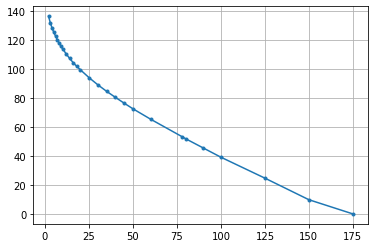

In [33]:
plt.plot(k_list, reconstruction_error, '.-')
plt.grid()
plt.show()